In [1]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from transformers import RobertaTokenizer, RobertaForMaskedLM, RobertaConfig, DataCollatorForLanguageModeling, get_cosine_schedule_with_warmup
from datasets import load_dataset

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
warmup_step_ratio = 0.1
num_epochs = 20
batch_size = 32
max_length = 512

In [3]:
dataset = load_dataset("allenai/c4", "realnewslike", split="train[:10000]")
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
collator = DataCollatorForLanguageModeling(tokenizer)

dataset = dataset.map(
    lambda examples: tokenizer(
        examples["text"],
        truncation=True,
        max_length=max_length,
    ),
    remove_columns=dataset.column_names,
    batched=True,
);

batches = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collator)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/512 [00:00<?, ?it/s]

In [4]:
# HuggingFace公式のRobertaForMaskedLMを使用（ランダム初期化）
config = RobertaConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=512,  # H
    num_hidden_layers=12,  # n_transformer_blocks
    num_attention_heads=8,  # h
    intermediate_size=512 * 4,  # FFN hidden dimension
    max_position_embeddings=514,  # RoBERTa default (512 + 2)
    type_vocab_size=1,
    pad_token_id=tokenizer.pad_token_id,
)

model = RobertaForMaskedLM(config)
device = torch.device("mps")
model = model.to(device)

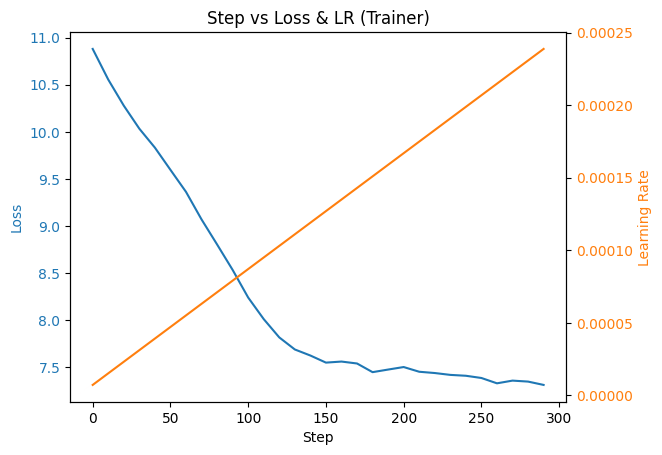

KeyboardInterrupt: 

In [5]:
# ==========================================
# Transformers公式Trainerを使った実験
# ==========================================
from transformers import Trainer, TrainingArguments, TrainerCallback

# 可視化用のコールバック
class VisualizationCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.lrs = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            self.lrs.append(logs.get("learning_rate", 0))
            self.visualize()
    
    def visualize(self):
        clear_output(wait=True)
        
        fig, ax1 = plt.subplots()
        
        # 左軸: loss
        steps = [i * 10 for i in range(len(self.losses))]  # logging_steps=10
        ax1.plot(steps, self.losses, color="tab:blue")
        ax1.set_xlabel("Step")
        ax1.set_ylabel("Loss", color="tab:blue")
        ax1.tick_params(axis="y", labelcolor="tab:blue")
        
        # 右軸: learning rate
        ax2 = ax1.twinx()
        ax2.plot(steps, self.lrs, color="tab:orange")
        ax2.set_ylabel("Learning Rate", color="tab:orange")
        ax2.tick_params(axis="y", labelcolor="tab:orange")
        
        plt.title("Step vs Loss & LR (Trainer)")
        plt.show()

# 新しいモデルを作成（前のトレーニングの影響を避ける）
model_trainer = RobertaForMaskedLM(config)
model_trainer = model_trainer.to(device)

# TrainingArguments - 手動ループと同じ設定
training_args = TrainingArguments(
    output_dir="./trainer_output",
    overwrite_output_dir=True,
    num_train_epochs=num_epochs,
    per_device_train_batch_size=32,
    learning_rate=5e-4,
    weight_decay=0.0,
    warmup_ratio=warmup_step_ratio,
    lr_scheduler_type="cosine",
    logging_steps=10,
    save_strategy="no",  # 保存しない（実験用）
    report_to="none",  # wandb等を使わない
    dataloader_num_workers=0,  # MPSの互換性のため
)

# コールバックを作成
viz_callback = VisualizationCallback()

# Trainer初期化
trainer = Trainer(
    model=model_trainer,
    args=training_args,
    train_dataset=dataset,
    data_collator=collator,
    callbacks=[viz_callback],
)

# トレーニング実行
print("=== Starting training with Transformers Trainer ===")
result = trainer.train()

# 最終結果を表示
print("\n=== Training complete ===")
print(f"Final loss: {viz_callback.losses[-1]:.4f}")
print(f"Loss history (every 10 steps): {dict([(i*10, f'{v:.2f}') for i, v in enumerate(viz_callback.losses) if i % 10 == 0])}")

In [7]:
print("\n=== Training complete ===")
print(f"Final loss: {viz_callback.losses[-1]:.4f}")
print(f"Loss history (every 10 steps): {dict([(i*10, f'{v:.2f}') for i, v in enumerate(viz_callback.losses)])}")


=== Training complete ===
Final loss: 7.3142
Loss history (every 10 steps): {0: '10.88', 10: '10.55', 20: '10.28', 30: '10.03', 40: '9.83', 50: '9.60', 60: '9.36', 70: '9.07', 80: '8.80', 90: '8.53', 100: '8.24', 110: '8.01', 120: '7.82', 130: '7.69', 140: '7.63', 150: '7.55', 160: '7.56', 170: '7.54', 180: '7.45', 190: '7.48', 200: '7.50', 210: '7.45', 220: '7.44', 230: '7.42', 240: '7.41', 250: '7.39', 260: '7.33', 270: '7.36', 280: '7.35', 290: '7.31'}
